In [1]:
!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_02-1551.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_21-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_00-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_47-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_50-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_25-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_20-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_62-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_52-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_36-2048.tfrec  
  inflating: dataset/tfrecords/train/file_trai

In [3]:
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import imgaug as ia
import cv2
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg
from utils import generate_2d_guassian

In [4]:
from dataset_builder import DatasetBuilder

In [5]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [4]:
def prep_example(example):
  image = example['image']
  xs = example['keypoints/x']
  ys = example['keypoints/y']
  return image, xs, ys

In [ ]:
ds = tf.data.TFRecordDataset(ds_builder.train_filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE) #create dataset
ds = ds.map(ds_builder.parse_tfrecord_fn, num_parallel_calls = tf.data.experimental.AUTOTUNE)
ds = ds.map(prep_example, num_parallel_calls = tf.data.experimental.AUTOTUNE )
ds = ds.take(1)

In [ ]:
it = iter(ds)
image, xs, ys = next(it)



---
Working with batches



In [ ]:
def np_augment(images, kps_x, kps_y):
    '''
    Augment the image and keypoints
    Only augment the valid keypoints (not (0, 0)) and all keypoints has to be augemted in image shape (hasnt been resized)
    :param kpts_x, kpts_y: x and y coordisnate in shape of (number of kpts):
    '''
    batch_of_kpsoi = [] 
    batch_of_indices = []
    for i in range(ds_builder.batch_size):
      # one instance of a batch
      xs = kps_x[i]
      ys = kps_y[i]
      image = images[i]

      # to store
      imgaug_kps = []
      indices = []
      for i, kp in enumerate(zip(xs, ys)):
        if 0 < kp[0] < image.shape[1] and 0 < kp[1] < image.shape[0]:
          imgaug_kps.append(Keypoint(x = kp[0], y = kp[1]))
          indices.append(i)
      
      kpsoi = KeypointsOnImage(imgaug_kps, shape = image.shape)
      batch_of_kpsoi.append(kpsoi)
      batch_of_indices.append(indices)

    #augment
    seed = np.random.randint(2**32-1)
    ia.seed(1)
    seq = iaa.Sequential([
      iaa.Fliplr(0.5),
      # aplly Gaussian with 30% and sigma = 1.5
      iaa.Sometimes(0.3, iaa.GaussianBlur((0, 1.5))),
      iaa.OneOf([
                  # Strengthen or weaken the contrast in each image.
                  iaa.LinearContrast((0.85, 1.15)),
                  # Drop out some pixels
                  iaa.Dropout((0, 0.05), per_channel=0.5),
                  iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05), per_channel=0.5),
                  # Make some images brighter and some darker.
                  # In 20% of all cases, we sample the multiplier once per channel,
                  # which can end up changing the color of the images.
                  iaa.Multiply((0.85, 1.15), per_channel=0.2),
                  # Apply affine transformations to each image.
                  # Scale/zoom them, translate/move them, rotate them and she
                  ]),
      # affine-> affect keypoints
      iaa.Affine(scale = (0.75, 1.25), translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, rotate = (-25, 25)),
      ], random_order = True) #cause rotate/scale then flip can be problematic
    
    aug_imgs_batch, aug_kps_batch = seq(images = images, keypoints = batch_of_kpsoi)

    # pad the invisible keypoints
    output_kpts_x_batch = np.zeros(shape = (ds_builder.batch_size, ds_builder.num_keypoints) , dtype = np.float32)
    output_kpts_y_batch = np.zeros(shape = (ds_builder.batch_size, ds_builder.num_keypoints) , dtype = np.float32)

    for i in range(ds_builder.batch_size):
      arr = aug_kps_batch[i].to_xy_array()
      indices = batch_of_indices[i]
      for j, xy in zip(indices, arr):
          output_kpts_x_batch[i, j] = xy[0]
          output_kpts_y_batch[i, j] = xy[1]

    return np.clip(aug_imgs_batch, 0, 1.0), output_kpts_x_batch, output_kpts_y_batch
  
def tf_augment(image, kpts_x, kpts_y):
    return tf.numpy_function(np_augment, [image, kpts_x, kpts_y], (tf.float32, tf.float32, tf.float32))

In [ ]:
def np_gen_heatmaps_batch(kps_x_batch, kps_y_batch):
  heatmaps_batch = []
  for kps_x, kps_y in zip(kps_x_batch, kps_y_batch):
    heatmaps_batch.append(ds_builder.np_gen_heatmaps(kps_x, kps_y))
  return np.array(heatmaps_batch, dtype = np.float32)
def tf_gen_heatmaps_batch(kps_x_batch, kps_y_batch):
    return tf.numpy_function(np_gen_heatmaps_batch, [kps_x_batch, kps_y_batch], tf.float32)

In [ ]:
def prepare_train_example(example):
    # Getting all the needed data first
    raw_image = example['image']
    raw_image_height = example['height']
    raw_image_width = example['width']
    kps_x = example['keypoints/x']
    kps_y = example['keypoints/y']


    # Recal x, y in (256, 256)
    h_ratio = ds_builder.image_shape[0] / raw_image_height
    w_ratio = ds_builder.image_shape[1] / raw_image_width
    kps_x = kps_x * tf.cast(w_ratio, tf.float32) 
    kps_y = kps_y * tf.cast(h_ratio, tf.float32) 

    image = tf.image.resize(raw_image, (ds_builder.image_shape[0], ds_builder.image_shape[1]))

    return image, kps_x, kps_y

In [ ]:
def np_prepare_train_labels(images_batch, kps_x_batch, kps_y_batch):
  # Augmentation
  aug_images_batch, aug_kps_x_batch, aug_kps_y_batch = np_augment(images_batch, kps_x_batch, kps_y_batch)
  
  # Heatmaps 
  # recal x, y from (256, 256) -> (64, 64)
  w_ratio = ds_builder.label_shape[1] / ds_builder.image_shape[1]
  h_ratio = ds_builder.label_shape[0] / ds_builder.image_shape[0]
  heatmaps_batch = np_gen_heatmaps_batch(aug_kps_x_batch*w_ratio, aug_kps_y_batch*h_ratio)

  return aug_images_batch, heatmaps_batch
def tf_prepare_train_labels(images_batch, kps_x_batch, kps_y_batch):
    return tf.numpy_function(np_prepare_train_labels, [images_batch, kps_x_batch, kps_y_batch], (tf.float32, tf.float32))

Skip above


---



In [ ]:
def make_heatmaps(keypoint_xs, keypoint_ys):
  '''
    Usages:
      Make heatmaps using gaussian 2D from xs and ys
    Args:
      Keypoints: should rescale into heatmaps' space (64, 64)
  '''
  x = tf.cast(tf.math.round(keypoint_xs), dtype=tf.int32)
  y = tf.cast(tf.math.round(keypoint_ys), dtype=tf.int32)

  num_heatmaps = 17
  heatmap_array = tf.TensorArray(tf.float32, num_heatmaps) # num_keypoints

  for i in range(num_heatmaps):
    gaussian = generate_2d_guassian(64, 64, y[i], x[i])
    heatmap_array = heatmap_array.write(i, gaussian)
  
  heatmaps = heatmap_array.stack()
  heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
  return heatmaps


In [ ]:
keypoint_xs = xs * (64.0 / tf.cast(tf.shape(image)[1], tf.float32))
keypoint_ys = ys * (64.0 / tf.cast(tf.shape(image)[0], tf.float32))
mask = tf.cast(xs>0, )

In [ ]:
hms = make_heatmaps(keypoint_xs, keypoint_ys)

(-0.5, 255.5, 255.5, -0.5)

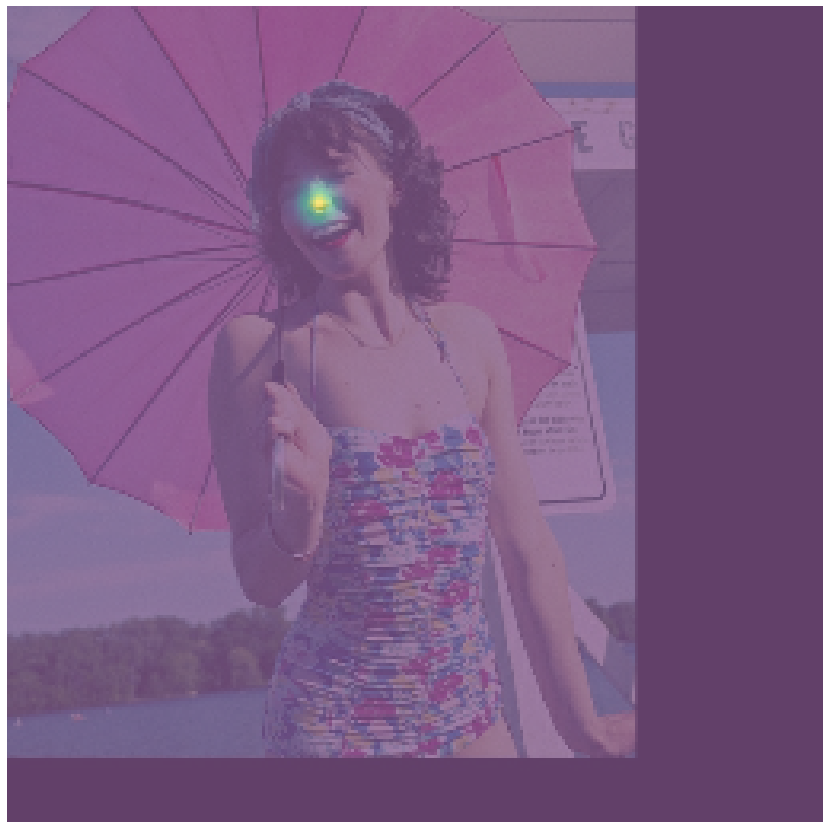

In [ ]:
fig = plt.figure(figsize=(15, 15))
img = tf.image.resize(image, (256, 256))
plt.imshow(img, cmap = 'gray', alpha = 0.5)
h = tf.image.resize(hms, (256, 256))
plt.imshow(h[:, :, 0], alpha = 0.5)
plt.axis("off")



---
New augments



Skip above
---



In [6]:
ds_train, ds_valid = ds_builder.build_datasets()

In [7]:
def heatmaps_to_keypoints_v1(heatmaps):
  '''
  :param heatmaps: shape(64, 64, number of keypoints)
  :return np.array
  '''
  flattened_heatmaps = tf.reshape(heatmaps, (64*64, 17)).numpy()
  keypoints = np.zeros(shape=(17, 3), dtype=np.float32)
  for i in range(17):
    heatmap = flattened_heatmaps[:, i]
    index = np.argmax(heatmap)
    x = index%64
    y = index//64
    conf = heatmap[y*64 + x]
    keypoints[i, 0] = x
    keypoints[i, 1] = y
    keypoints[i, 2] = conf
  return keypoints

In [8]:
it = iter(ds_train)

In [9]:
imgs_batch, hms_batch = next(it)

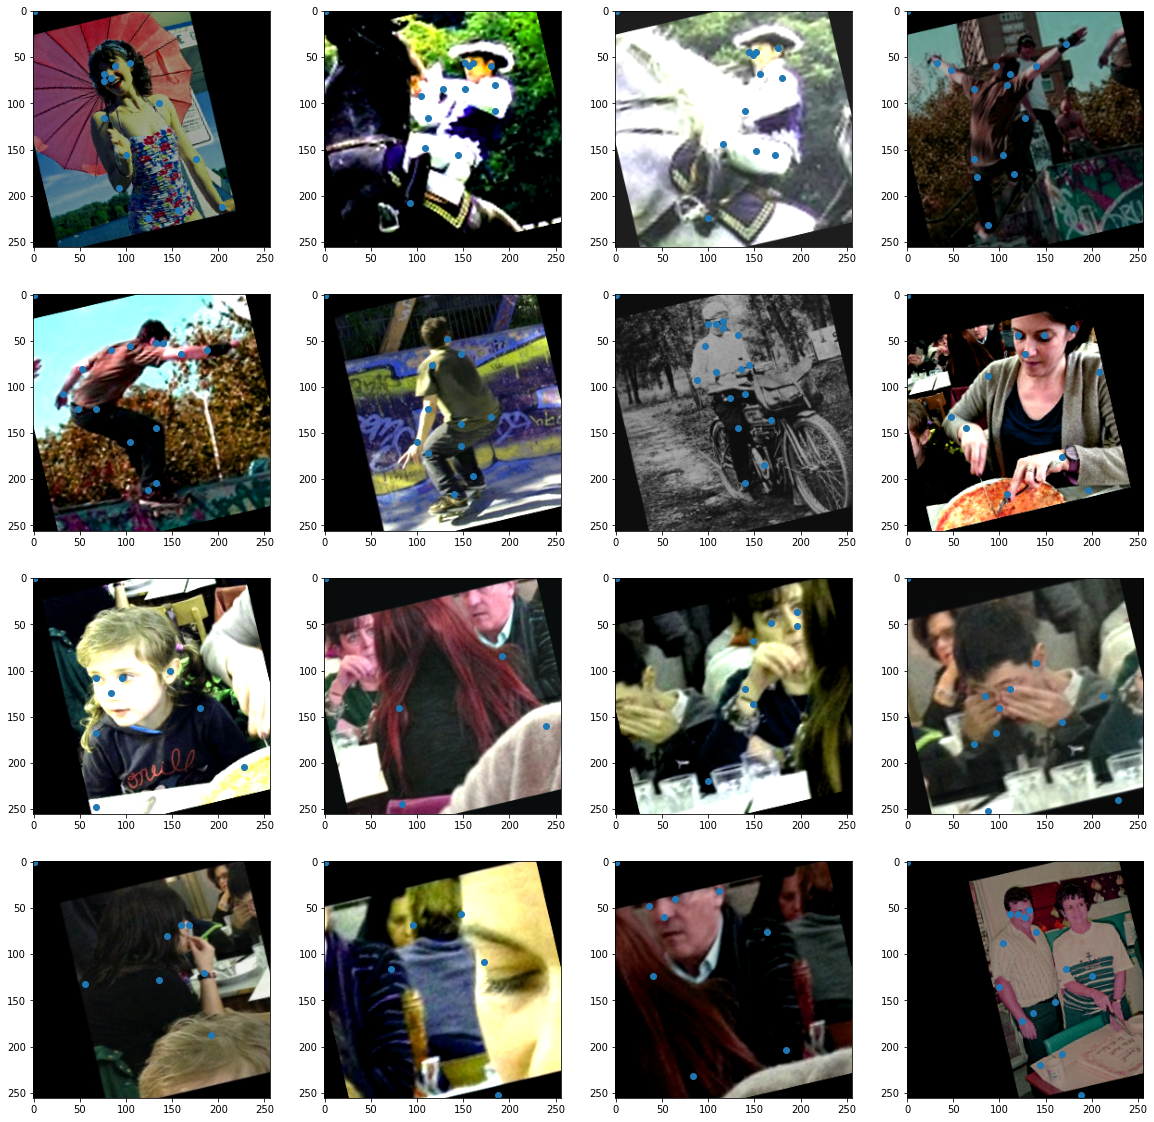

In [8]:
fig = plt.figure(figsize=(20, 20))
rows = 4
cols = 4
for i in range(rows*cols):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(imgs_batch[i])
  keypoints = heatmaps_to_keypoints_v1(hms_batch[i])*256/64
  plt.scatter(keypoints[:, 0], keypoints[:, 1])

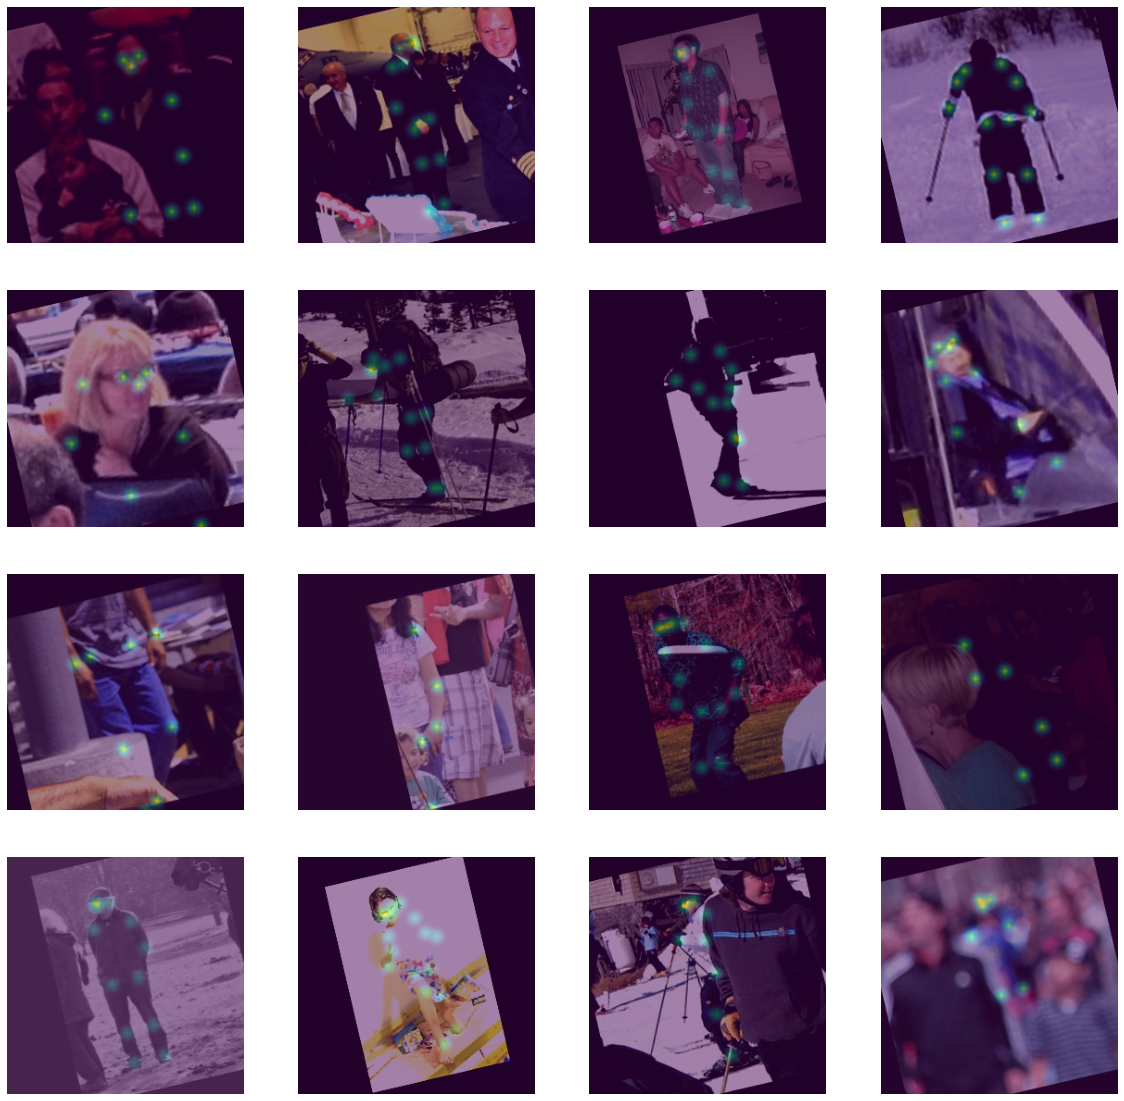

In [10]:
fig = plt.figure(figsize=(20, 20))
rows = 4
cols = 4
for i in range(rows*cols):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(imgs_batch[i])
  plt.imshow(imgs_batch[i], cmap = 'gray', alpha = 0.5)
  h = tf.image.resize(hms_batch[i], (256, 256))
  plt.imshow(tf.reduce_sum(h, axis = -1), alpha = 0.5)
  plt.axis("off")

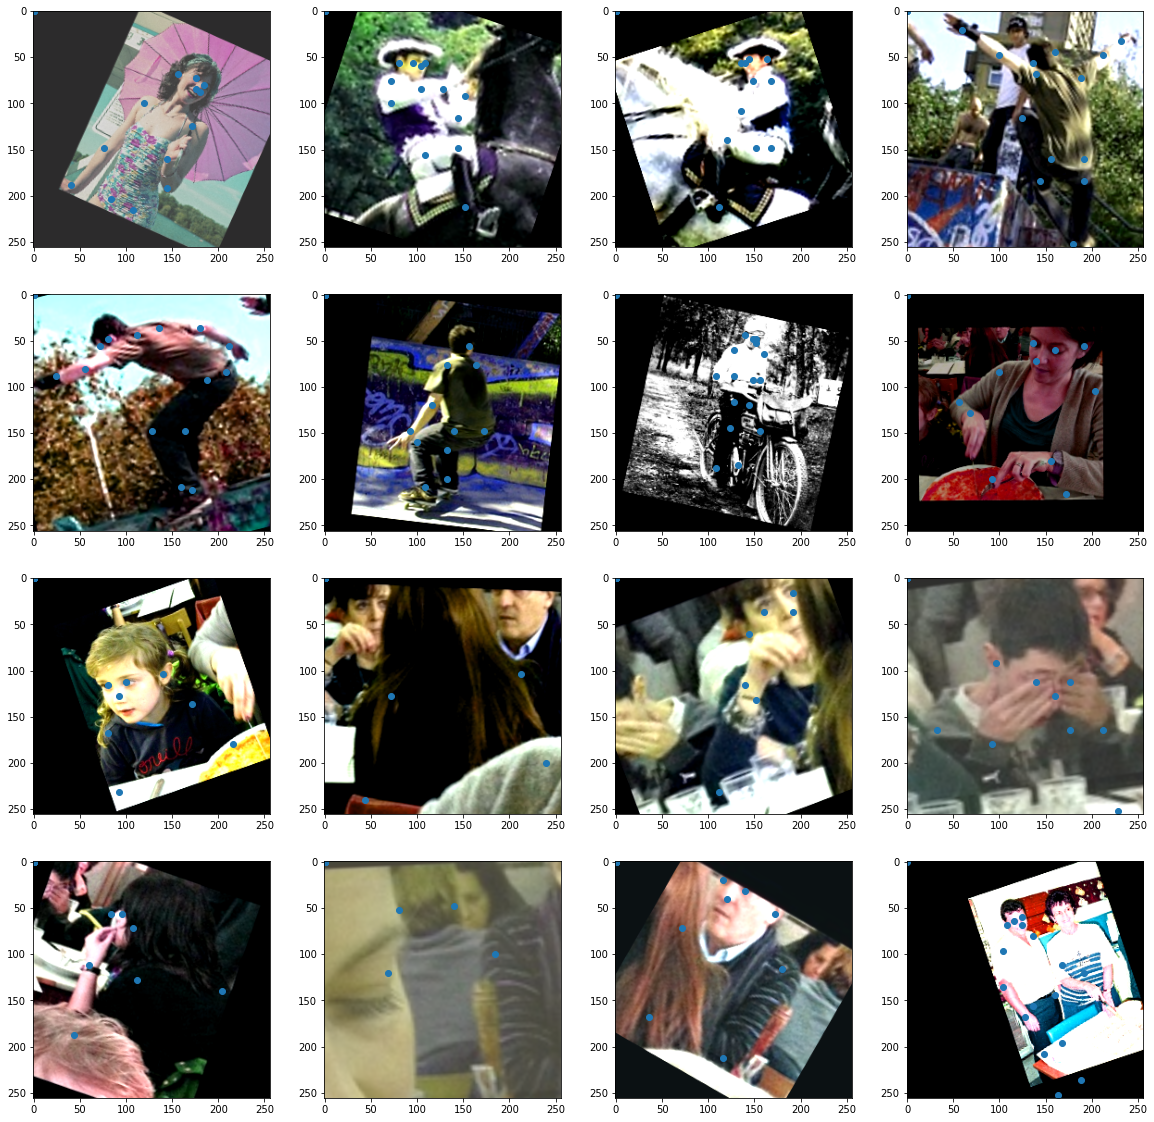

In [10]:
fig = plt.figure(figsize=(20, 20))
rows = 4
cols = 4
for i in range(rows*cols):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(imgs_batch[i])
  keypoints = heatmaps_to_keypoints_v1(hms_batch[i])*256/64
  plt.scatter(keypoints[:, 0], keypoints[:, 1])

In [ ]:
ds = ds_builder.get_ds_prediction()
ds = ds.take(1)

In [ ]:
it = iter(ds)

In [ ]:
image, meta = next(it)

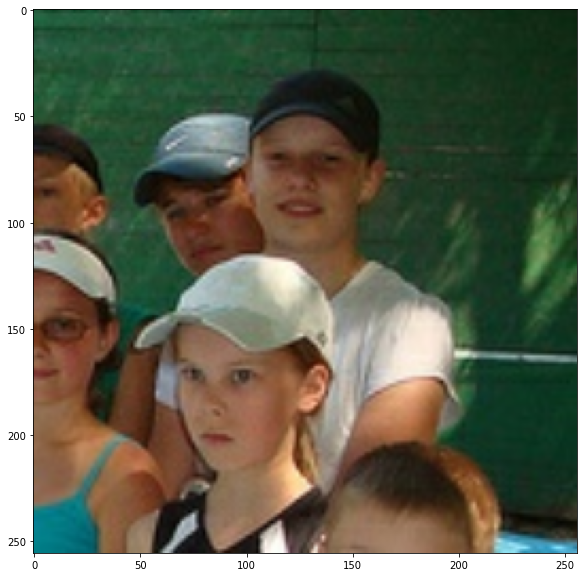

In [ ]:
plt.figure(figsize = (10, 10))
plt.imshow(image[15])

- random_brightness: 
  - delta should be [0.0, 1.0) -> choose 0.2
  - value of a pixel will be randomly added a value from [-0.2, 0.2]
  - need to clip to 1.0

- random_constrast: 
  - For each channel, this Op computes the mean of the image pixels in the channel and then adjusts each component x of each pixel to (x - mean) * contrast_factor + mean.
  - chose lower 0.5, upper 2
  - need to clip to 1.0

- random_saturation:
  - image is an RGB image or images. The image saturation is adjusted by converting the images to HSV and multiplying the saturation (S) channel by saturation_factor and clipping. The images are then converted back to RGB.
  - chose lower 0.75, upper 1.25
  - already clipped -> still need to do it

- random_hue:
  - image is an RGB image. The image hue is adjusted by converting the image(s) to HSV and rotating the hue channel (H) by delta. The image is then converted back to RGB.

 - max_delta must be in the interval [0, 0.5].
 - chose 0.1

 


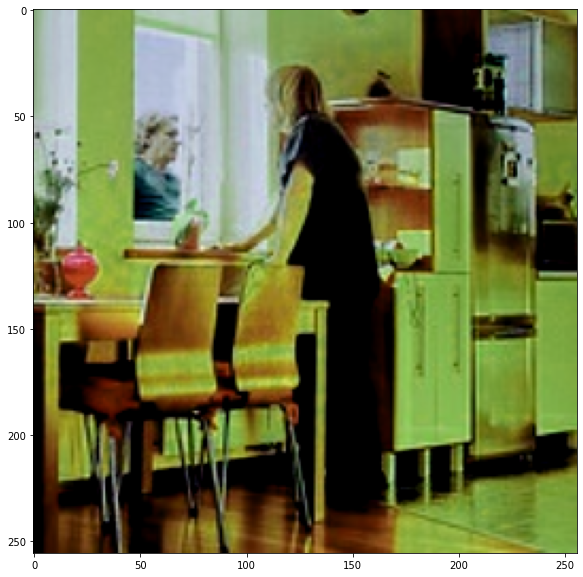

In [ ]:
plt.figure(figsize = (10, 10))
img = tf.image.random_brightness(image[0], 0.2)
img = tf.image.random_contrast(img, 0.5, 2.0)
img = tf.image.random_saturation(img, 0.75, 1.25)
img = tf.image.random_hue(img, 0.1)
img = tf.clip_by_value(img, 0.0, 1.0)
plt.imshow(img)

In [ ]:
new_image

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.14604588, 0.34117648, 0.23119378],
        [0.14906366, 0.34419426, 0.23421156],
        [0.15368988, 0.34882048, 0.23883778],
        ...,
        [0.06337942, 0.14479934, 0.07393284],
        [0.06062542, 0.13786   , 0.06908616],
        [0.05882893, 0.13333334, 0.06592459]],

       [[0.15869218, 0.35928312, 0.24793532],
        [0.16112936, 0.36172032, 0.25037253],
        [0.16486558, 0.36545652, 0.25410873],
        ...,
        [0.06672311, 0.15087318, 0.0786416 ],
        [0.06485911, 0.14482385, 0.07468493],
        [0.06364318, 0.14087777, 0.07210392]],

       [[0.17807886, 0.38704047, 0.27359998],
        [0.17962606, 0.38858768, 0.2751472 ],
        [0.18199791, 0.39095953, 0.27751905],
        ...,
        [0.07184897, 0.16018437, 0.08586013],
        [0.07134934, 0.15549941, 0.08326783],
        [0.07102342, 0.15244332, 0.08157682]],

       ...,

       [[0.05483076, 0.5051348 , 0.53715533],
        [0.05